In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Preparation**

This is *Smartphone Image Denoising Dataset* downloaded from,<br>
https://www.eecs.yorku.ca/~kamel/sidd/dataset.php

In [81]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
import pathlib
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import cv2

from tqdm.notebook import tqdm
import random

In [ ]:
if 'SIDD_Small_sRGB_Only' not in os.listdir(): 
    !wget https://www.dropbox.com/s/jgx2yt7959tun3s/SIDD_Small_sRGB_Only.zip
    get_ipython().system_raw("7z x \*.zip && rm *.zip")

In [ ]:
# def create_paths_df(root_dir):
#     root = pathlib.Path(root_dir)
#     img_paths = list(root.rglob("*.PNG*"))
#     img_paths_lst = [str(path) for path in img_paths]

#     noisy_lst = []
#     gt_lst = []
#     counter = 1 # Used for adding serial numbers to the images
#     for p in img_paths_lst:
#         img_type = p.split("/")[-1].split('_')[-3]
#         if img_type=="NOISY":
#             serial_path = p.split(".")[0][:-3]+str(counter)+".PNG"
#             noisy_lst.append(serial_path)
#         elif img_type=="GT":
#             serial_path = p.split(".")[0][:-3]+str(counter)+".PNG"
#             gt_lst.append(serial_path)
#         counter+=1
#     paths_df = pd.DataFrame(list(zip(noisy_lst, gt_lst)), columns =['Noisy_paths', 'GT_paths'])
#     return paths_df

In [4]:
def create_paths_df(root_dir):
    root = pathlib.Path(root_dir)
    img_paths = list(root.rglob("*.PNG*"))
    img_paths_lst = [str(path) for path in img_paths]

    noisy_lst = []
    gt_lst = []
    for p in img_paths_lst:
        img_type = p.split("/")[-1].split('_')[-3]
        if img_type=="NOISY":
            noisy_lst.append(p)
        elif img_type=="GT":
            gt_lst.append(p)
    paths_df = pd.DataFrame(list(zip(noisy_lst, gt_lst)), columns =['Noisy_paths', 'GT_paths'])
    return paths_df

In [5]:
paths_df = create_paths_df("SIDD_Small_sRGB_Only")
paths_df.head()

,Noisy_paths,GT_paths
0,SIDD_Small_sRGB_Only/Data/0097_005_N6_03200_02...,SIDD_Small_sRGB_Only/Data/0097_005_N6_03200_02...
1,SIDD_Small_sRGB_Only/Data/0193_009_IP_00800_02...,SIDD_Small_sRGB_Only/Data/0193_009_IP_00800_02...
2,SIDD_Small_sRGB_Only/Data/0002_001_S6_00100_00...,SIDD_Small_sRGB_Only/Data/0002_001_S6_00100_00...
3,SIDD_Small_sRGB_Only/Data/0166_007_IP_01600_01...,SIDD_Small_sRGB_Only/Data/0166_007_IP_01600_01...
4,SIDD_Small_sRGB_Only/Data/0136_006_IP_00800_00...,SIDD_Small_sRGB_Only/Data/0136_006_IP_00800_00...


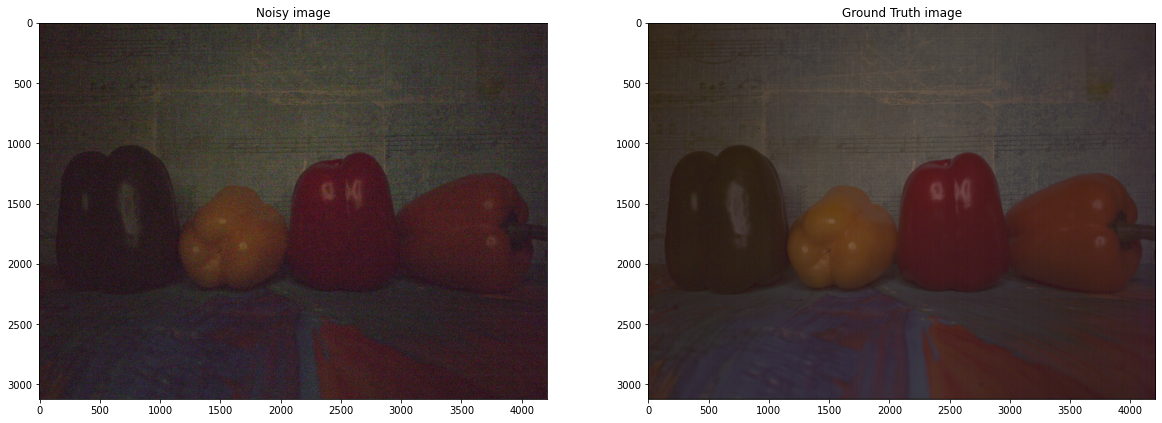

In [26]:
# Randomly displaying an image pair
rand_image_idx = random.choice(range(160))

noisy_img = cv2.imread(paths_df['Noisy_paths'][rand_image_idx])
gt_img = cv2.imread(paths_df['GT_paths'][rand_image_idx])

noisy_img = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB)
gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)

f, axarr = plt.subplots(1,2, figsize=(20,20))
axarr[0].imshow(noisy_img)
axarr[0].title.set_text("Noisy image")

axarr[1].imshow(gt_img)
axarr[1].title.set_text("Ground Truth image")

# **EDA**

## **Analysis on the meta-data**

Google Pixel =>	 20.62 %
IPhone 7 =>	 33.75 %
Samsung S6 =>	 21.88 %
LG G4 =>	 10.0 %
Motorola Nexus 6 => 13.75 %



<BarContainer object of 5 artists>

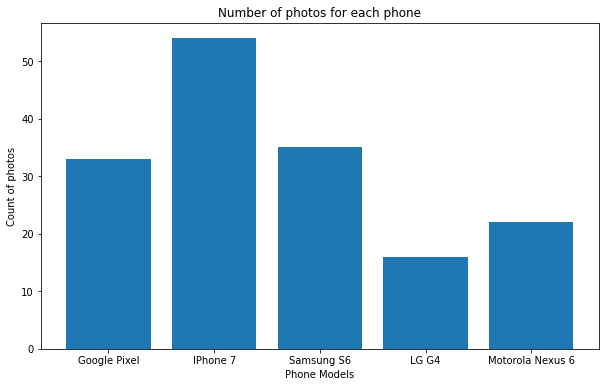

In [119]:
# Number of photos from each Phone model
GP_count=0
IP_count=0
S6_count=0
G4_count=0
N6_count=0

noisy_paths = paths_df['Noisy_paths'].values    # We could have taken GT paths also. After all, the images are in pairs!
for p in noisy_paths:
    phone_model = p.split("/")[2].split("_")[2]
    if "GP" == phone_model:
        GP_count+=1
    if "IP" == phone_model:
        IP_count+=1
    if "S6" == phone_model:
        S6_count+=1
    if "G4" == phone_model:
        G4_count+=1
    if "N6" == phone_model:
        N6_count+=1

total = GP_count+IP_count+S6_count+G4_count+N6_count
print("Google Pixel =>\t",round(GP_count/total*100,2),"%")
print("IPhone 7 =>\t",round(IP_count/total*100,2),"%")
print("Samsung S6 =>\t",round(S6_count/total*100,2),"%")
print("LG G4 =>\t",round(G4_count/total*100,2),"%")
print("Motorola Nexus 6 =>",round(N6_count/total*100,2),"%")
print()

plt.figure(figsize=(10,6))
plt.xlabel("Phone Models") 
plt.ylabel("Count of photos")
plt.title("Number of photos for each phone")
plt.bar(["Google Pixel", "IPhone 7", "Samsung S6", "LG G4", "Motorola Nexus 6"], [GP_count, IP_count, S6_count, G4_count, N6_count])

<font color='purple'>**Observation:**</font>
<br>
We can see that majority of the photos have been clicked on IPhone 7, followed by Samsung S6 and Google Pixel. LG G4 has the least number of photos.

In [96]:
# Get unique ISO levels used in the dataset
noisy_paths = paths_df['Noisy_paths'].values    # We could have taken GT paths also. After all, the images are in pairs!
unique_iso_levels = set()
for p in noisy_paths:
    iso_level = p.split("/")[2].split("_")[3]
    unique_iso_levels.add(iso_level)
print("Unique ISO levels used:")
print(unique_iso_levels)

Unique ISO levels used:
{'00100', '00500', '02000', '00640', '10000', '00050', '06400', '00320', '01600', '03200', '00400', '00800', '01000', '00200'}


In [106]:
def visualize_heatmap(df, title, x_label, heat_strip_label="Number of photos", annot_=True):
    plt.figure(figsize=(18,10))
    ax = sns.heatmap(
        df,
        cmap="Blues",
        annot=annot_,
        cbar_kws={'label': heat_strip_label, 'orientation': 'vertical'},
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    ax.set_xlabel(x_label)
    ax.set_ylabel("Phones")
    plt.title(title)

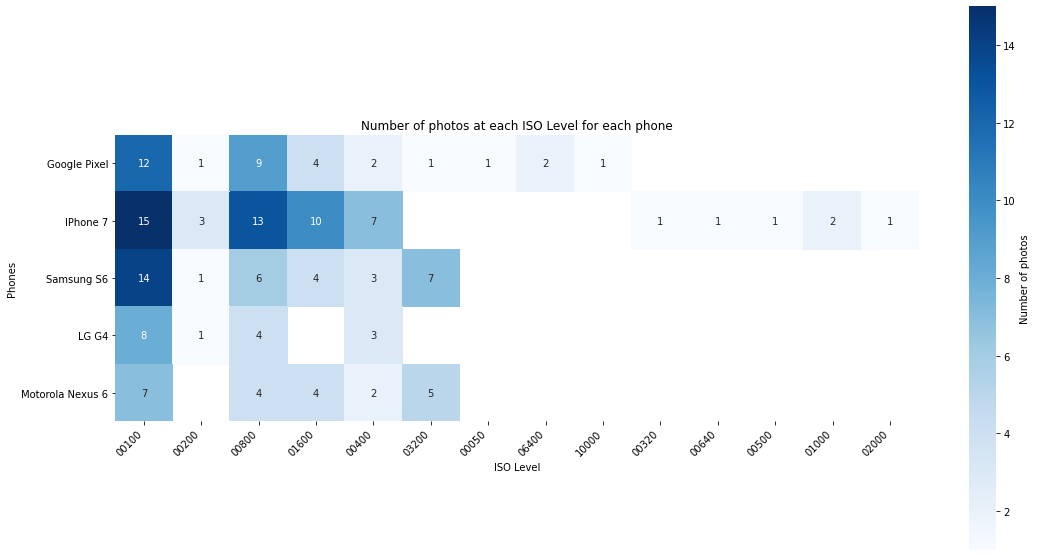

In [107]:
# Number of photos from each ISO level
GP_count={}
IP_count={}
S6_count={}
G4_count={}
N6_count={}

noisy_paths = paths_df['Noisy_paths'].values    # We could have taken GT paths also. After all, the images are in pairs!
for p in noisy_paths:
    phone_model = p.split("/")[2].split("_")[2]
    iso_level = p.split("/")[2].split("_")[3]
    if "GP" == phone_model:
        iso_exists = GP_count.get(iso_level)
        if iso_exists == None:
            GP_count[iso_level]=1
        else:
            GP_count[iso_level]+=1
    if "IP" == phone_model:
        iso_exists = IP_count.get(iso_level)
        if iso_exists == None:
            IP_count[iso_level]=1
        else:
            IP_count[iso_level]+=1
    if "S6" == phone_model:
        iso_exists = S6_count.get(iso_level)
        if iso_exists == None:
            S6_count[iso_level]=1
        else:
            S6_count[iso_level]+=1
    if "G4" == phone_model:
        iso_exists = G4_count.get(iso_level)
        if iso_exists == None:
            G4_count[iso_level]=1
        else:
            G4_count[iso_level]+=1
    if "N6" == phone_model:
        iso_exists = N6_count.get(iso_level)
        if iso_exists == None:
            N6_count[iso_level]=1
        else:
            N6_count[iso_level]+=1

noise_level_df = pd.DataFrame([GP_count, IP_count, S6_count, G4_count, N6_count]).rename(pd.Series(["Google Pixel", "IPhone 7", "Samsung S6", "LG G4", "Motorola Nexus 6"]))
visualize_heatmap(noise_level_df, "Number of photos at each ISO Level for each phone", "ISO Level")

<font color='purple'>**Observation:**</font>
<br>
There are total 14 unique ISO level settings used in the dataset. Most of the photos are clicked at a low ISO setting. Most used ISO settings are 100 and 800 followed by 1600,400 and 3200. Higher the exposure, brighter the image will be and vice-versa.

In [95]:
# Get unique Shutter speeds used in the dataset
noisy_paths = paths_df['Noisy_paths'].values    # We could have taken GT paths also. After all, the images are in pairs!
unique_shutter_speeds = set()
for p in noisy_paths:
    shutter_speed = p.split("/")[2].split("_")[4]
    unique_shutter_speeds.add(shutter_speed)
print("Unique Shutter speeds used:")
print(unique_shutter_speeds)

Unique Shutter speeds used:
{'00080', '01250', '04160', '06400', '00320', '00180', '00125', '00100', '00500', '02500', '04000', '00750', '08460', '00050', '01600', '00800', '01000', '03100', '02000', '01520', '00640', '00060', '00025', '00160', '00200', '00350', '00250', '00020', '00400', '03200'}


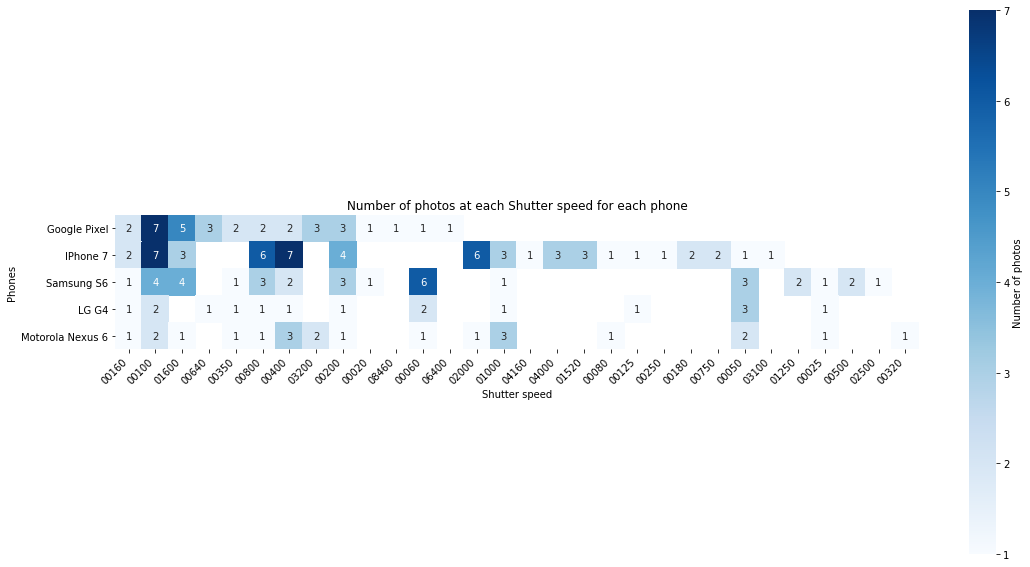

In [109]:
# Number of photos for every Shutter speed
GP_count={}
IP_count={}
S6_count={}
G4_count={}
N6_count={}

noisy_paths = paths_df['Noisy_paths'].values    # We could have taken GT paths also. After all, the images are in pairs!
for p in noisy_paths:
    phone_model = p.split("/")[2].split("_")[2]
    shutter_speed = p.split("/")[2].split("_")[4]
    if "GP" == phone_model:
        shutter_exist = GP_count.get(shutter_speed)
        if shutter_exist == None:
            GP_count[shutter_speed]=1
        else:
            GP_count[shutter_speed]+=1
    if "IP" == phone_model:
        shutter_exist = IP_count.get(shutter_speed)
        if shutter_exist == None:
            IP_count[shutter_speed]=1
        else:
            IP_count[shutter_speed]+=1
    if "S6" == phone_model:
        shutter_exist = S6_count.get(shutter_speed)
        if shutter_exist == None:
            S6_count[shutter_speed]=1
        else:
            S6_count[shutter_speed]+=1
    if "G4" == phone_model:
        shutter_exist = G4_count.get(shutter_speed)
        if shutter_exist == None:
            G4_count[shutter_speed]=1
        else:
            G4_count[shutter_speed]+=1
    if "N6" == phone_model:
        shutter_exist = N6_count.get(shutter_speed)
        if shutter_exist == None:
            N6_count[shutter_speed]=1
        else:
            N6_count[shutter_speed]+=1

shutter_speed_df = pd.DataFrame([GP_count, IP_count, S6_count, G4_count, N6_count]).rename(pd.Series(["Google Pixel", "IPhone 7", "Samsung S6", "LG G4", "Motorola Nexus 6"]))
visualize_heatmap(shutter_speed_df, "Number of photos at each Shutter speed for each phone", "Shutter speed")

<font color='purple'>**Observation:**</font>
<br>
Most of the photos are clicked at 100 shutter speed, followed by 400 and 800. Higher the shutter speed darker the image will be, and vice-versa.

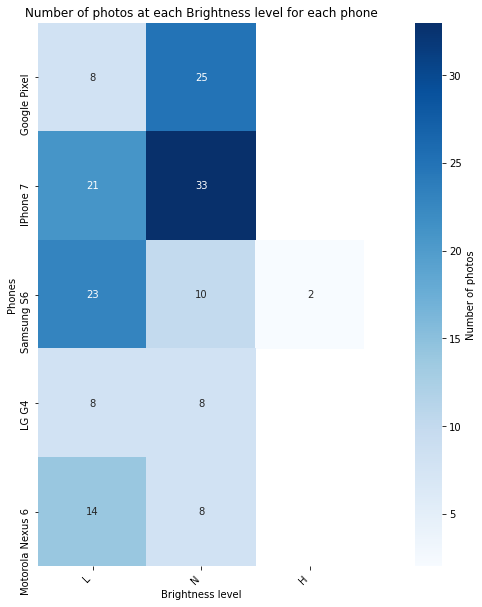

In [110]:
# Number of photos for every Brightness level
GP_count={}
IP_count={}
S6_count={}
G4_count={}
N6_count={}

noisy_paths = paths_df['Noisy_paths'].values    # We could have taken GT paths also. After all, the images are in pairs!
for p in noisy_paths:
    phone_model = p.split("/")[2].split("_")[2]
    brightness_level = p.split("/")[2][-1]
    if "GP" == phone_model:
        bright_exists = GP_count.get(brightness_level)
        if bright_exists == None:
            GP_count[brightness_level]=1
        else:
            GP_count[brightness_level]+=1
    if "IP" == phone_model:
        bright_exists = IP_count.get(brightness_level)
        if bright_exists == None:
            IP_count[brightness_level]=1
        else:
            IP_count[brightness_level]+=1
    if "S6" == phone_model:
        bright_exists = S6_count.get(brightness_level)
        if bright_exists == None:
            S6_count[brightness_level]=1
        else:
            S6_count[brightness_level]+=1
    if "G4" == phone_model:
        bright_exists = G4_count.get(brightness_level)
        if bright_exists == None:
            G4_count[brightness_level]=1
        else:
            G4_count[brightness_level]+=1
    if "N6" == phone_model:
        bright_exists = N6_count.get(brightness_level)
        if bright_exists == None:
            N6_count[brightness_level]=1
        else:
            N6_count[brightness_level]+=1

brightness_level_df = pd.DataFrame([GP_count, IP_count, S6_count, G4_count, N6_count]).rename(pd.Series(["Google Pixel", "IPhone 7", "Samsung S6", "LG G4", "Motorola Nexus 6"]))
visualize_heatmap(brightness_level_df, "Number of photos at each Brightness level for each phone", "Brightness level")

<font color='purple'>**Observation:**</font>
<br>
Majority of the photos are clicked in Normal brightness mode, followed by Low brightness. Only 2 photos are clicked at High brightness on Samsung S6.

In [128]:
# Resolution of image

GP_res={}
IP_res={}
S6_res={}
G4_res={}
N6_res={}

noisy_paths = paths_df['Noisy_paths'].values    # We could have taken GT paths also. After all, the images are in pairs!
for p in noisy_paths:
    phone_model = p.split("/")[2].split("_")[2]
    noisy_img = cv2.imread(p)
    img_resolution = str(noisy_img.shape[0:2])
    if "GP" == phone_model:
        res_exists = GP_res.get(img_resolution)
        if res_exists == None:
            GP_res[img_resolution]=1
        else:
            GP_res[img_resolution]+=1
    if "IP" == phone_model:
        res_exists = IP_res.get(img_resolution)
        if res_exists == None:
            IP_res[img_resolution]=1
        else:
            IP_res[img_resolution]+=1
    if "S6" == phone_model:
        res_exists = S6_res.get(img_resolution)
        if res_exists == None:
            S6_res[img_resolution]=1
        else:
            S6_res[img_resolution]+=1
    if "G4" == phone_model:
        res_exists = G4_res.get(img_resolution)
        if res_exists == None:
            G4_res[img_resolution]=1
        else:
            G4_res[img_resolution]+=1
    if "N6" == phone_model:
        res_exists = N6_res.get(img_resolution)
        if res_exists == None:
            N6_res[img_resolution]=1
        else:
            N6_res[img_resolution]+=1

In [129]:
res_df = pd.DataFrame([GP_res, IP_res, S6_res, G4_res, N6_res]).rename(pd.Series(["Google Pixel", "IPhone 7", "Samsung S6", "LG G4", "Motorola Nexus 6"]))
res_df.head()

,"(3044, 4048)","(3024, 4032)","(3000, 5328)","(2988, 5312)","(3120, 4208)"
Google Pixel,33.0,NaN,NaN,NaN,NaN
IPhone 7,NaN,54.0,NaN,NaN,NaN
Samsung S6,NaN,NaN,35.0,NaN,NaN
LG G4,NaN,NaN,NaN,16.0,NaN
Motorola Nexus 6,NaN,NaN,NaN,NaN,22.0


<font color='purple'>**Observation:**</font>
<br>
We can see each phone has its own image resolution. Every individual phone has same resolution photos.

## **Analysis on the Image data**

### Analysing the mean and std deviation on R,G & B channel of all images

In [141]:
noisy_paths = paths_df['Noisy_paths'].values

noisy_red_means = []
noisy_green_means = []
noisy_blue_means = []

noisy_red_std_dev = []
noisy_green_std_dev = []
noisy_blue_std_dev = []

for p in noisy_paths:
    noisy_img = cv2.imread(p)
    noisy_img = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB)

    red_channel_pixels = noisy_img[:,:,0]
    noisy_red_means.append(np.mean(red_channel_pixels))
    noisy_red_std_dev.append(np.std(red_channel_pixels))

    green_channel_pixels = noisy_img[:,:,1]
    noisy_green_means.append(np.mean(green_channel_pixels))
    noisy_green_std_dev.append(np.std(green_channel_pixels))

    blue_channel_pixels = noisy_img[:,:,2]
    noisy_blue_means.append(np.mean(blue_channel_pixels))
    noisy_blue_std_dev.append(np.std(blue_channel_pixels))

In [142]:
gt_paths = paths_df['GT_paths'].values

gt_red_means = []
gt_green_means = []
gt_blue_means = []

gt_red_std_dev = []
gt_green_std_dev = []
gt_blue_std_dev = []

for p in gt_paths:
    gt_img = cv2.imread(p)
    gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)

    red_channel_pixels = gt_img[:,:,0]
    gt_red_means.append(np.mean(red_channel_pixels))
    gt_red_std_dev.append(np.std(red_channel_pixels))

    green_channel_pixels = gt_img[:,:,1]
    gt_green_means.append(np.mean(green_channel_pixels))
    gt_green_std_dev.append(np.std(green_channel_pixels))

    blue_channel_pixels = gt_img[:,:,2]
    gt_blue_means.append(np.mean(blue_channel_pixels))
    gt_blue_std_dev.append(np.std(blue_channel_pixels))

Text(0.5, 0, 'Mean')

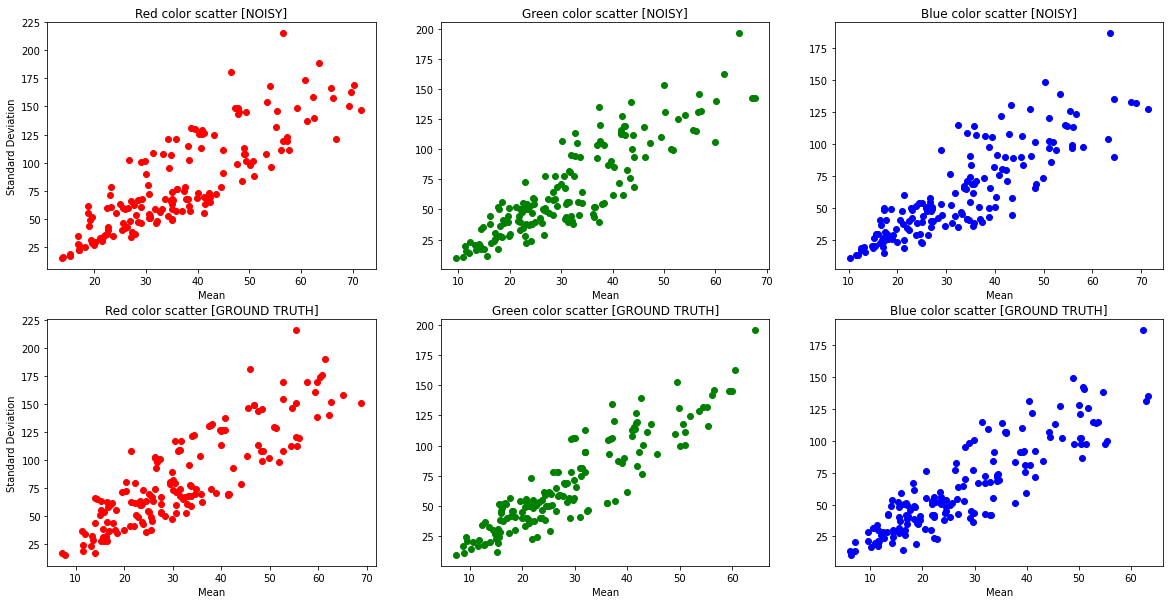

In [159]:
f, ax = plt.subplots(2,3, figsize=(20,10))
ax[0][0].scatter(noisy_red_std_dev, noisy_red_means, color='r')
ax[0][0].title.set_text("Red color scatter [NOISY]")
ax[0][0].set_xlabel("Mean")
ax[0][0].set_ylabel("Standard Deviation")

ax[0][1].scatter(noisy_green_std_dev, noisy_green_means, color='g')
ax[0][1].title.set_text("Green color scatter [NOISY]")
ax[0][1].set_xlabel("Mean")

ax[0][2].scatter(noisy_blue_std_dev, noisy_blue_means, color='b')
ax[0][2].title.set_text("Blue color scatter [NOISY]")
ax[0][2].set_xlabel("Mean")
#-----------------------------
ax[1][0].scatter(gt_red_std_dev, gt_red_means, color='r')
ax[1][0].title.set_text("Red color scatter [GROUND TRUTH]")
ax[1][0].set_xlabel("Mean")
ax[1][0].set_ylabel("Standard Deviation")

ax[1][1].scatter(gt_green_std_dev, gt_green_means, color='g')
ax[1][1].title.set_text("Green color scatter [GROUND TRUTH]")
ax[1][1].set_xlabel("Mean")

ax[1][2].scatter(gt_blue_std_dev, gt_blue_means, color='b')
ax[1][2].title.set_text("Blue color scatter [GROUND TRUTH]")
ax[1][2].set_xlabel("Mean")

<font color='purple'>**Observation:**</font>
<br>
It is seen that most of the mean pixel values are at a lower to medium value (darker to medium brightness images). Only few of them are very high value(bright images)

### Analysing distribution of flattened pixels of all images together

Text(0.5, 1.0, 'Noisy images pixel intensity distribution')

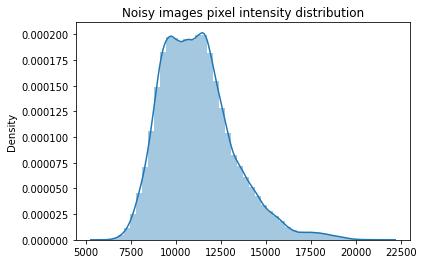

In [167]:
noisy_paths = paths_df['Noisy_paths'].values
noisy_flattened_imgs = []
for p in noisy_paths:
    noisy_img = cv2.imread(p)
    noisy_img = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB)
    noisy_img = cv2.resize(noisy_img, (2900, 4000),  interpolation = cv2.INTER_NEAREST)
    noisy_flattened_imgs.append(np.ravel(noisy_img))

falttened_sum_noisy = np.sum(np.array(noisy_flattened_imgs), axis=0)  # This will sum the pixel values of each pixel [each pixels is as column, each row is an image]

ax = sns.distplot(falttened_sum_noisy)
ax.set_title('Noisy images pixel intensity distribution')

Text(0.5, 1.0, 'Ground truth images pixel intensity distribution')

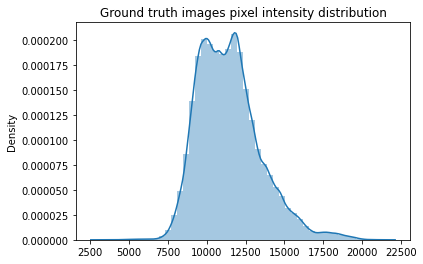

In [166]:
gt_paths = paths_df['GT_paths'].values
gt_flattened_imgs = []
for p in gt_paths:
    gt_img = cv2.imread(p)
    gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
    gt_img = cv2.resize(gt_img, (2900, 4000),  interpolation = cv2.INTER_NEAREST)
    gt_flattened_imgs.append(np.ravel(gt_img))

falttened_sum_gt = np.sum(np.array(gt_flattened_imgs), axis=0)  # This will sum the pixel values of each pixel [each pixels is as column, each row is an image]

ax = sns.distplot(falttened_sum_gt)
ax.set_title('Ground truth images pixel intensity distribution')

<font color='purple'>**Observation:**</font>
<br>
Thorugh this we can confirm that pixel intensities of all the images is similar and almost normally distributed.

### Image Histogram of few individual images

In [173]:
def get_histogram(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    histr_r = cv2.calcHist([img],[0],None,[256],[0,256])
    histr_g = cv2.calcHist([img],[1],None,[256],[0,256])
    histr_b = cv2.calcHist([img],[2],None,[256],[0,256])
    return histr_r, histr_g, histr_b, img

Text(0.5, 1.0, 'Ground truth image histogram')

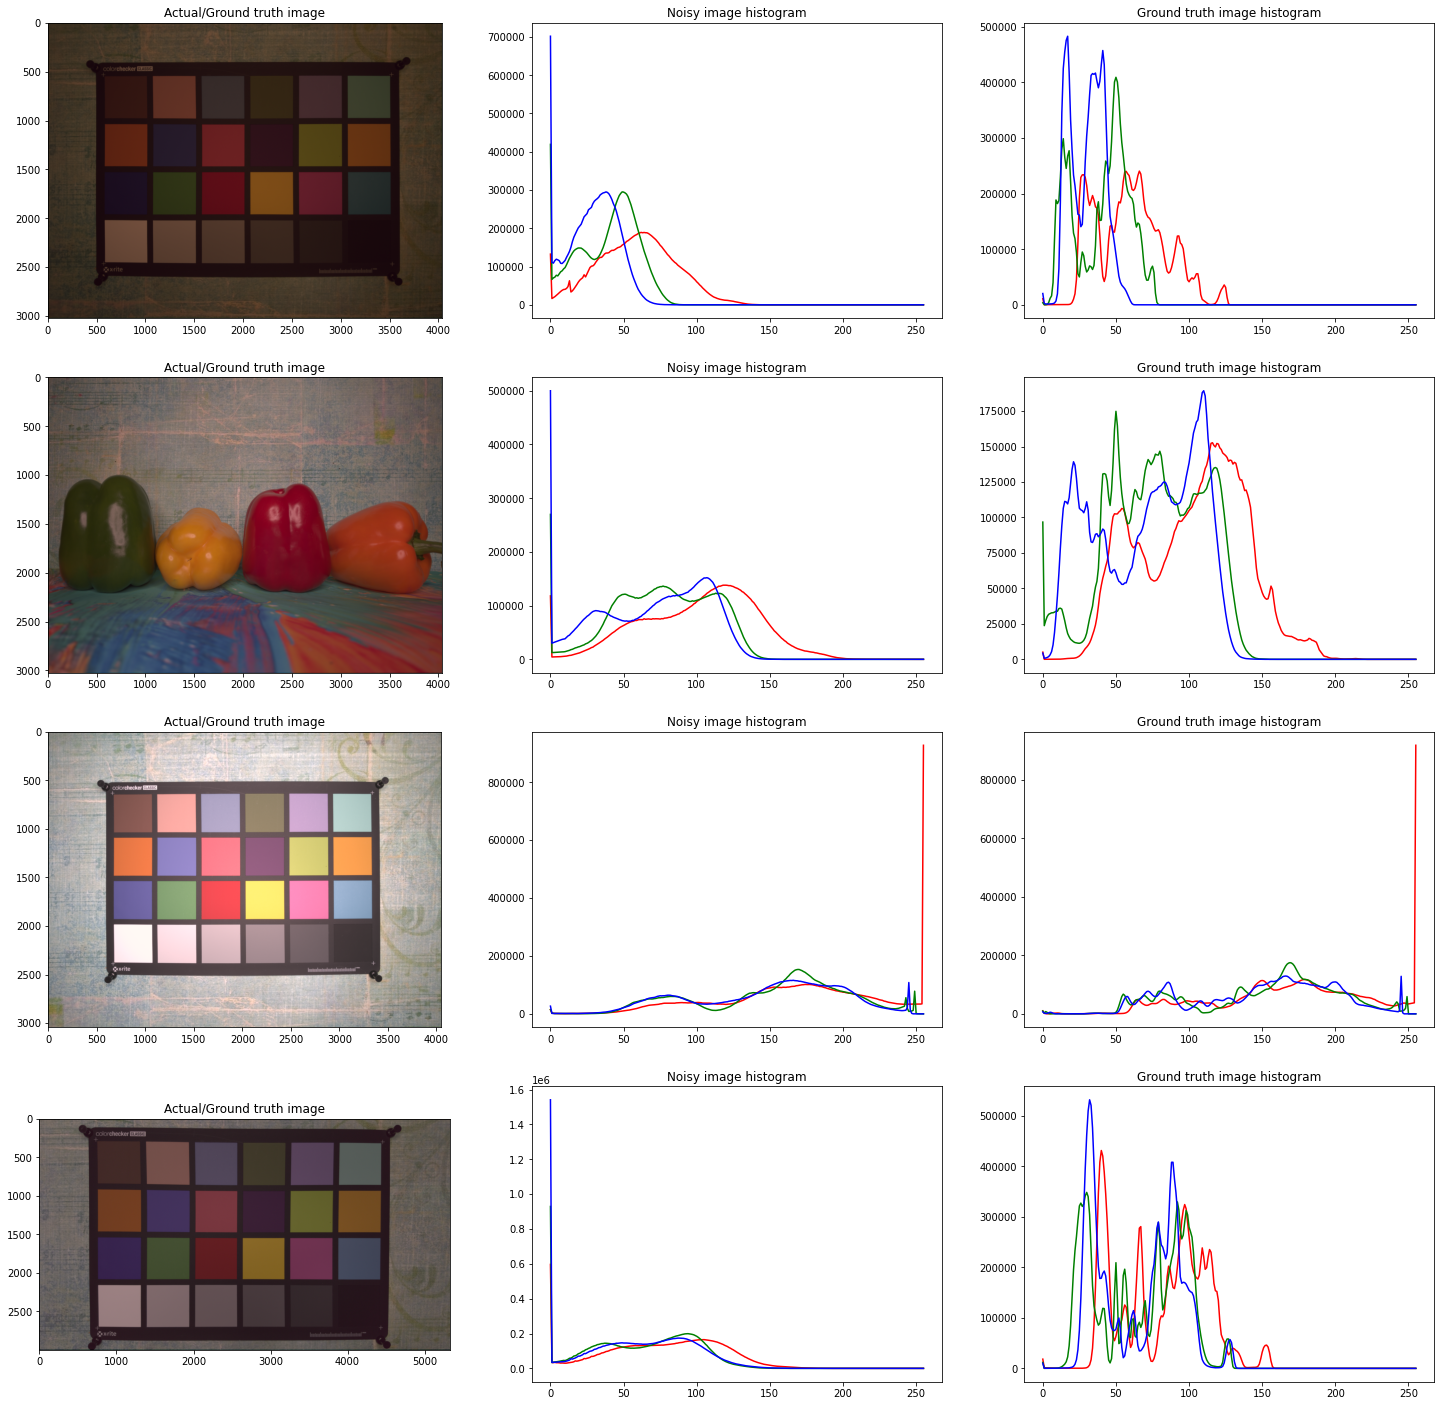

In [185]:
f,ax = plt.subplots(4,3, figsize=(25,25))

rand_image_idx = random.choice(range(160))
histr_r, histr_g, histr_b, img = get_histogram(paths_df['Noisy_paths'][rand_image_idx])
ax[0][1].plot(histr_r, color="r")
ax[0][1].plot(histr_g, color='g')
ax[0][1].plot(histr_b, color='b')
ax[0][1].set_title("Noisy image histogram")

histr_r, histr_g, histr_b, img = get_histogram(paths_df['GT_paths'][rand_image_idx])
ax[0][0].imshow(img)
ax[0][0].set_title("Actual/Ground truth image")

ax[0][2].plot(histr_r, color="r")
ax[0][2].plot(histr_g, color='g')
ax[0][2].plot(histr_b, color='b')
ax[0][2].set_title("Ground truth image histogram")

#------------
rand_image_idx = random.choice(range(160))
histr_r, histr_g, histr_b, img = get_histogram(paths_df['Noisy_paths'][rand_image_idx])
ax[1][1].plot(histr_r, color="r")
ax[1][1].plot(histr_g, color='g')
ax[1][1].plot(histr_b, color='b')
ax[1][1].set_title("Noisy image histogram")

histr_r, histr_g, histr_b, img = get_histogram(paths_df['GT_paths'][rand_image_idx])
ax[1][0].imshow(img)
ax[1][0].set_title("Actual/Ground truth image")

ax[1][2].plot(histr_r, color="r")
ax[1][2].plot(histr_g, color='g')
ax[1][2].plot(histr_b, color='b')
ax[1][2].set_title("Ground truth image histogram")

#------------
rand_image_idx = random.choice(range(160))
histr_r, histr_g, histr_b, img = get_histogram(paths_df['Noisy_paths'][rand_image_idx])
ax[2][1].plot(histr_r, color="r")
ax[2][1].plot(histr_g, color='g')
ax[2][1].plot(histr_b, color='b')
ax[2][1].set_title("Noisy image histogram")

histr_r, histr_g, histr_b, img = get_histogram(paths_df['GT_paths'][rand_image_idx])
ax[2][0].imshow(img)
ax[2][0].set_title("Actual/Ground truth image")

ax[2][2].plot(histr_r, color="r")
ax[2][2].plot(histr_g, color='g')
ax[2][2].plot(histr_b, color='b')
ax[2][2].set_title("Ground truth image histogram")

#------------
rand_image_idx = random.choice(range(160))
histr_r, histr_g, histr_b, img = get_histogram(paths_df['Noisy_paths'][rand_image_idx])
ax[3][1].plot(histr_r, color="r")
ax[3][1].plot(histr_g, color='g')
ax[3][1].plot(histr_b, color='b')
ax[3][1].set_title("Noisy image histogram")

histr_r, histr_g, histr_b, img = get_histogram(paths_df['GT_paths'][rand_image_idx])
ax[3][0].imshow(img)
ax[3][0].set_title("Actual/Ground truth image")

ax[3][2].plot(histr_r, color="r")
ax[3][2].plot(histr_g, color='g')
ax[3][2].plot(histr_b, color='b')
ax[3][2].set_title("Ground truth image histogram")

<font color='purple'>**Observation:**</font>
<br>
It can be observed that the noisy images has smooth distribution of pixel intensity as compared to the original images. The reason for this is that, whenever there is noise in an image, it means the camera has failed to capture the color info for those pixels (due to various reasons) and hence, to fill the 'no color' in those pixels, it is filled with some random value by the camera software. Due to this random values (noise) the pixel values gets smoothed out. 